## Look at the age 'around' the OMZ

- Can I just look at the 'hull' around the OMZ and show the o2 decrease/age increase in a scatter plot?

In [1]:
import intake
import pathlib
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from fastprogress import progress_bar
from dask.diagnostics import ProgressBar
from cmip6_omz.boundaries import omz_boundaries
from cmip6_omz.utils import cmip6_collection, o2_models
from cmip6_omz.upstream_stash import concat_time
from cmip6_omz.omz_tools import o2sat

from cmip6_preprocessing.utils import cmip6_dataset_id
from cmip6_preprocessing.drift_removal import match_and_remove_trend
from cmip6_preprocessing.preprocessing import combined_preprocessing
from cmip6_preprocessing.postprocessing import merge_variables, concat_experiments, interpolate_grid_label
from xarrayutils.file_handling import write
from distributed import LocalCluster, Client

from cmip6_omz.units import convert_mol_m3_mymol_kg
from cmip6_omz.omz_tools import mask_basin
import xesmf as xe
# target_grid = xe.util.grid_global(0.5, 0.5)
import numpy as np

In [3]:
col = cmip6_collection(zarr=False)

kwargs = {
    "preprocess": combined_preprocessing,
    "cdf_kwargs": {"use_cftime": True, "chunks": {"time": 1}, "engine": "h5netcdf"},
    "zarr_kwargs": {"use_cftime": True, "consolidated": True},
    "aggregate": False,
}
cat = col.search(
    #     source_id=o2_models(),
    source_id=[
#         "ACCESS-ESM1-5",
#         "CNRM-ESM2-1",
        "CanESM5",
        "CanESM5-CanOE",
        "GFDL-CM4",
        "GFDL-ESM4",
#         "IPSL-CM6A-LR",
#         "MIROC-ES2L",
#         "MPI-ESM1-2-HR",
#         "MPI-ESM1-2-LR",
#         "MRI-ESM2-0",
#         "NorESM2-LM",
#         "NorESM2-MM",
#         "UKESM1-0-LL",
        #         "CESM2",
        #         "CESM2-WACCM",
        #         "CMCC-ESM2",
        #         "EC-Earth3-CC",
        #         "KIOST-ESM",
        
        #         "MPI-ESM-1-2-HAM",
        #         "IPSL-CM5A2-INCA",

        
    ],
    variable_id=["agessc", "o2", ],#'thetao', 'so'
    experiment_id=["historical", "ssp585"],
    # just for testing
    
#     member_id = ['r2i1p1f2','r1i2p1f1','r1i1p1f1']
)
ddict = cat.to_dataset_dict(**kwargs)

Dataframe size before picking latest version: 2363
Getting latest version...

Dataframe size after picking latest version: 2258

Done....


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.dcpp_init_year.version.time_range.path'


### Add the GFDL age if necessary

In [4]:
# Brute Force add the GFDL age
# TODO: Make this nicer with the original netcdf files (not tonight though)
col_gfdl = cmip6_collection(zarr=True)
# BUG: There is something weird going on in the reading process here
# Just drop everything that is not GFDL
df = col_gfdl.df
df = df.iloc[ ['GFDL' in i for i in df['source_id']], :]
df = df.iloc[ ['agessc' in i for i in df['variable_id']], :]
col_gfdl.df = df
cat_gfdl = col_gfdl.search(
    source_id=[
        "GFDL-CM4",
        "GFDL-ESM4", 
    ],
    variable_id=["agessc"],
    experiment_id=["historical", "ssp585"],
)

ddict_gfdl_age = cat_gfdl.to_dataset_dict(**kwargs)
ddict_gfdl_age = {k:ds.chunk({'time':1, 'x':-1, 'y':-1}) for k, ds in ddict_gfdl_age.items()}
ddict.update(ddict_gfdl_age)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.version.zstore'


In [5]:
# Load all trend files
flist = list(pathlib.Path('/projects/GEOCLIM/LRGROUP/jbusecke/projects_data/cmip6_control_drifts/').absolute().glob('*.nc'))
trend_dict = {}
for f in progress_bar(flist):
    trend_dict[f.stem] = xr.open_mfdataset([f])

# detrend
ddict_detrended = match_and_remove_trend(
    ddict,
    trend_dict,
    check_mask=False # should be deactivated once the trends are completed (i have a few in there now that dont have a nanmask applied)
)

/home/jbusecke/code/cmip6_preprocessing/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CCCma.CanESM5.historical.r19i1p1f1.Omon.gn.v20190429.agessc
  warnings.warn(nomatch_msg)
/home/jbusecke/code/cmip6_preprocessing/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CCCma.CanESM5.historical.r19i1p1f1.Omon.gn.v20190429.agessc
  warnings.warn(nomatch_msg)
/home/jbusecke/code/cmip6_preprocessing/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for ScenarioMIP.CCCma.CanESM5.ssp585.r5i1p1f1.Oyr.gn.v20190429.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/cmip6_preprocessing/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CCCma.CanESM5.historical.r24i1p1f1.Omon.gn.v20190429.agessc
  warnings.warn(nomatch_msg)
/home/jbusecke/code/cmip6_preprocessing/cmip6_preprocessing/postprocessing.py:60: UserWarning: 

In [6]:
# combine in time (only needed for netcdf collection)
ddict_time_combined = concat_time(ddict_detrended)
ddict_experiments_combined = concat_experiments(ddict_time_combined)

In [10]:
# filter only the ones that are actually combined (some have only historical)
ddict_experiments_combined_filtered = {}
for name, ds in ddict_experiments_combined.items():
    if len(ds.time)>2000:
        ddict_experiments_combined_filtered[name] = ds
    else:
        print(ds)
ddict_combined = merge_variables(ddict_experiments_combined_filtered)
# TODO...is this still not improved?
# ddict_combined = interpolate_grid_label(ddict_experiments_combined_filtered)
# ddict_combined.update(ddict_combined_add)

<xarray.Dataset>
Dimensions:        (time: 1980, lev: 45, y: 291, x: 360, bnds: 2, vertex: 4)
Coordinates:
  * time           (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bounds    (time, bnds) object dask.array<chunksize=(1, 2), meta=np.ndarray>
  * lev            (lev) float64 3.047 9.454 16.36 ... 5.375e+03 5.625e+03
    lev_bounds     (lev, bnds) float64 0.0 6.194 6.194 ... 5.5e+03 5.75e+03
  * y              (y) int32 0 1 2 3 4 5 6 7 ... 283 284 285 286 287 288 289 290
  * x              (x) int32 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
    lat            (y, x) float64 -78.39 -78.39 -78.39 ... 50.51 50.23 50.01
    lon            (y, x) float64 73.5 74.5 75.5 76.5 ... 72.95 72.96 72.99
    lat_verticies  (y, x, vertex) float64 -78.49 -78.29 -78.29 ... 50.0 49.98
    lon_verticies  (y, x, vertex) float64 73.0 73.0 74.0 74.0 ... 73.0 73.0 73.0
    lon_bounds     (bnds, y, x) float64 73.0 74.0 75.0 76.0 ... 72.95 72.97 73.0
    lat_bounds     (bnds,

/home/jbusecke/code/cmip6_preprocessing/cmip6_preprocessing/postprocessing.py:113: UserWarning: Match attributes ['experiment_id'] not found in any of the datasets.         This can happen when several combination functions are used.
  warnings.warn(


In [11]:
# ddict_time_combined['ACCESS-ESM1-5.gn.historical.Omon.r1i1p1f1.agessc']

In [12]:
np.sort(list(ddict_combined))

array(['CanESM5-CanOE.gn.Omon.r1i1p2f1', 'CanESM5-CanOE.gn.Omon.r2i1p2f1',
       'CanESM5-CanOE.gn.Omon.r3i1p2f1', 'CanESM5.gn.Omon.r10i1p1f1',
       'CanESM5.gn.Omon.r10i1p2f1', 'CanESM5.gn.Omon.r1i1p1f1',
       'CanESM5.gn.Omon.r1i1p2f1', 'CanESM5.gn.Omon.r2i1p1f1',
       'CanESM5.gn.Omon.r2i1p2f1', 'CanESM5.gn.Omon.r3i1p1f1',
       'CanESM5.gn.Omon.r3i1p2f1', 'CanESM5.gn.Omon.r4i1p1f1',
       'CanESM5.gn.Omon.r4i1p2f1', 'CanESM5.gn.Omon.r5i1p1f1',
       'CanESM5.gn.Omon.r5i1p2f1', 'CanESM5.gn.Omon.r6i1p1f1',
       'CanESM5.gn.Omon.r6i1p2f1', 'CanESM5.gn.Omon.r7i1p1f1',
       'CanESM5.gn.Omon.r7i1p2f1', 'CanESM5.gn.Omon.r8i1p1f1',
       'CanESM5.gn.Omon.r8i1p2f1', 'CanESM5.gn.Omon.r9i1p1f1',
       'CanESM5.gn.Omon.r9i1p2f1', 'GFDL-CM4.gn.Omon.r1i1p1f1',
       'GFDL-CM4.gr.Omon.r1i1p1f1', 'GFDL-ESM4.gn.Omon.r1i1p1f1',
       'GFDL-ESM4.gr.Omon.r1i1p1f1'], dtype='<U30')

In [13]:
# set up dask
from dask.distributed import LocalCluster, Client
mem_total = 128
workers = 3
threads = 4 # 4*6 seemed to work quite well, but I would like this to perform a bit better
cluster = LocalCluster(
    memory_limit=f"{int(mem_total/workers)}GiB",
    dashboard_address=9999,
    threads_per_worker=threads,
    n_workers = workers,
                      )
client = Client(cluster)
client

/scratch/gpfs/jbusecke/conda_tigercpu/envs/cmip6_omz/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 9999 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39255 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:39255/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:39255/status,Workers: 3
Total threads: 12,Total memory: 126.00 GiB
Comm: tcp://127.0.0.1:32795,Workers: 3
Dashboard: http://127.0.0.1:39255/status,Total threads: 12
Started: Just now,Total memory: 126.00 GiB
Comm: tcp://127.0.0.1:35456,Total threads: 4
Dashboard: http://127.0.0.1:42937/status,Memory: 42.00 GiB
Nanny: tcp://127.0.0.1:32961,


In [14]:
# shorter periods for testing
hist_slice = slice('1850', '1870')
fut_slice = slice('2080', '2100')

# TODO: switch
# hist_slice = slice('1850', '1950')
# fut_slice = slice('2000', '2100')

## Play around with the masking

In [45]:
# ds = ddict_combined['CanESM5-CanOE.gn.Omon.r1i1p2f1']
# ds = ddict_combined['']
ds = mask_basin(ds)

# make mask
# Historical o2 region
hist_o2 = ds.o2.sel(time=slice('1850', '1900')).mean('time').load()
hist_o2 = convert_mol_m3_mymol_kg(hist_o2)
ssp_o2 = ds.o2.sel(time=slice('2050', '2100')).mean('time').load()
ssp_o2 = convert_mol_m3_mymol_kg(ssp_o2)

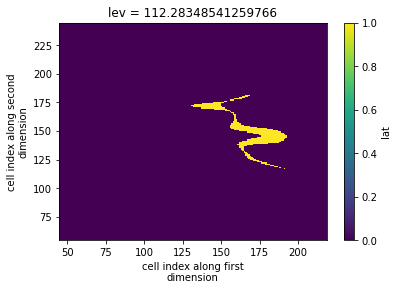

In [49]:
hist_mask = np.logical_and(hist_o2>=120, hist_o2<=160)
ssp_mask = np.logical_and(ssp_o2>=120, ssp_o2<=160)
mask = np.logical_and(abs(mask.lat)<=20, np.logical_and(hist_mask, ssp_mask))

mask.isel(lev=10).plot()

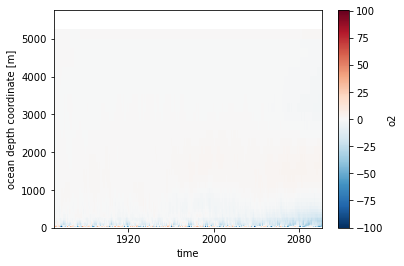

In [50]:
a = convert_mol_m3_mymol_kg(ds.o2.where(mask).mean(['x', 'y']))

(a - a.isel(time=0)).plot(x='time')

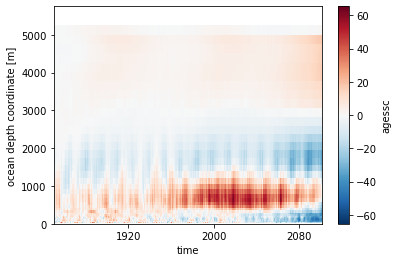

In [51]:
a = ds.agessc.where(mask).mean(['x', 'y'])


(a - a.isel(time=0)).plot(x='time')

## Earlier Stuff

In [13]:
# ds = ddict_combined['CanESM5.gn.Omon.r1i1p1f1']
ds = ddict_combined['CanESM5.gn.Omon.r1i1p1f1']
# ds = ddict_combined['MIROC-ES2L.gn.Omon.r2i1p1f2']
ds = ds.drop([va for va in ds.data_vars if va not in ['o2', 'agessc']])
ds

<xarray.Dataset>
Dimensions:        (time: 5412, lev: 45, y: 291, x: 360, bnds: 2, vertex: 4)
Coordinates:
  * time           (time) object 1850-01-16 12:00:00 ... 2300-12-16 12:00:00
    time_bounds    (time, bnds) object dask.array<chunksize=(1, 2), meta=np.ndarray>
  * lev            (lev) float64 3.047 9.454 16.36 ... 5.375e+03 5.625e+03
    lev_bounds     (lev, bnds) float64 0.0 6.194 6.194 ... 5.5e+03 5.75e+03
  * y              (y) int32 0 1 2 3 4 5 6 7 ... 283 284 285 286 287 288 289 290
  * x              (x) int32 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
    lat            (y, x) float64 -78.39 -78.39 -78.39 ... 50.51 50.23 50.01
    lon            (y, x) float64 73.5 74.5 75.5 76.5 ... 72.95 72.96 72.99
    lat_verticies  (y, x, vertex) float64 -78.49 -78.29 -78.29 ... 50.0 49.98
    lon_verticies  (y, x, vertex) float64 73.0 73.0 74.0 74.0 ... 73.0 73.0 73.0
    lon_bounds     (bnds, y, x) float64 73.0 74.0 75.0 76.0 ... 72.95 72.97 73.0
    lat_bounds     (bnds, y, x) float64 -78.49 -14.06 -13.92 ... 50.24 50.05
Dimensions without coordinates: bnds, vertex
Data variables:
    o2             (time, lev, y, x) float64 dask.array<chunksize=(1, 45, 291, 360), meta=np.ndarray>
    agessc         (time, lev, y, x) float64 dask.array<chunksize=(1, 45, 291, 360), meta=np.ndarray>
Attributes: (12/38)
    CCCma_pycmor_hash:     33c30511acc319a98240633965a04ca99c26427e
    Conventions:           CF-1.7 CMIP-6.2
    branch_method:         Spin-up documentation
    contact:               ec.cccma.info-info.ccmac.ec@canada.ca
    data_specs_version:    01.00.29
    external_variables:    areacello volcello
    ...                    ...
    variant_label:         r1i1p1f1
    version:               v20190429
    license:               CMIP6 model data produced by The Government of Can...
    cmor_version:          3.4.0
    intake_esm_varname:    None
    original_key:          CanESM5.gn.Omon.r1i1p1f1.agessc

In [14]:
ds

<xarray.Dataset>
Dimensions:        (time: 5412, lev: 45, y: 291, x: 360, bnds: 2, vertex: 4)
Coordinates:
  * time           (time) object 1850-01-16 12:00:00 ... 2300-12-16 12:00:00
    time_bounds    (time, bnds) object dask.array<chunksize=(1, 2), meta=np.ndarray>
  * lev            (lev) float64 3.047 9.454 16.36 ... 5.375e+03 5.625e+03
    lev_bounds     (lev, bnds) float64 0.0 6.194 6.194 ... 5.5e+03 5.75e+03
  * y              (y) int32 0 1 2 3 4 5 6 7 ... 283 284 285 286 287 288 289 290
  * x              (x) int32 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
    lat            (y, x) float64 -78.39 -78.39 -78.39 ... 50.51 50.23 50.01
    lon            (y, x) float64 73.5 74.5 75.5 76.5 ... 72.95 72.96 72.99
    lat_verticies  (y, x, vertex) float64 -78.49 -78.29 -78.29 ... 50.0 49.98
    lon_verticies  (y, x, vertex) float64 73.0 73.0 74.0 74.0 ... 73.0 73.0 73.0
    lon_bounds     (bnds, y, x) float64 73.0 74.0 75.0 76.0 ... 72.95 72.97 73.0
    lat_bounds     (bnds, y, x) float64 -78.49 -14.06 -13.92 ... 50.24 50.05
Dimensions without coordinates: bnds, vertex
Data variables:
    o2             (time, lev, y, x) float64 dask.array<chunksize=(1, 45, 291, 360), meta=np.ndarray>
    agessc         (time, lev, y, x) float64 dask.array<chunksize=(1, 45, 291, 360), meta=np.ndarray>
Attributes: (12/38)
    CCCma_pycmor_hash:     33c30511acc319a98240633965a04ca99c26427e
    Conventions:           CF-1.7 CMIP-6.2
    branch_method:         Spin-up documentation
    contact:               ec.cccma.info-info.ccmac.ec@canada.ca
    data_specs_version:    01.00.29
    external_variables:    areacello volcello
    ...                    ...
    variant_label:         r1i1p1f1
    version:               v20190429
    license:               CMIP6 model data produced by The Government of Can...
    cmor_version:          3.4.0
    intake_esm_varname:    None
    original_key:          CanESM5.gn.Omon.r1i1p1f1.agessc

In [15]:
# client.close()
# cluster.close()

In [16]:
def _calc_o2_sat(ds):
#     ds['o2sat'] = o2sat(ds.thetao, ds.so)
#     ds['aou'] = ds.o2sat - ds.o2
    return ds

with ProgressBar():
    ds_hist = _calc_o2_sat(ds).sel(time=hist_slice).mean('time').load()
    ds_fut = _calc_o2_sat(ds).sel(time=fut_slice).mean('time').load()

/scratch/gpfs/jbusecke/conda_tigercpu/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/scratch/gpfs/jbusecke/conda_tigercpu/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/scratch/gpfs/jbusecke/conda_tigercpu/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [17]:

lon = xr.DataArray(np.arange(0,360, 1), dims=['x'])
lat = xr.DataArray(np.arange(-90, 90, 1), dims=['y'])

lon = xr.ones_like(lat) * lon
lat = lat * xr.ones_like(lon)
target_grid = xr.Dataset().assign_coords(lon=lon, lat=lat)
target_grid
def regrid(ds):
    regridder = xe.Regridder(ds, target_grid, 'bilinear', periodic=True, ignore_degenerate=True)
    ds_out = regridder(ds)
    ds_out = ds_out.assign_coords(x=ds_out.lon.isel(y=0), y=ds_out.lat.isel(x=0))
    return ds_out

In [52]:
target_lon = 270
# target_lat = 0
target_lat = -15
target_lev = 500

In [53]:
o2_contours = [10, 20, 60, 100, 140, 180]

In [54]:
from xarrayutils.plotting import linear_piecewise_scale

In [55]:
%matplotlib inline

### Fixed example for CanESM5

/scratch/gpfs/jbusecke/conda_tigercpu/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/scratch/gpfs/jbusecke/conda_tigercpu/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


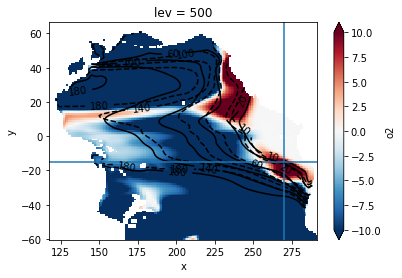

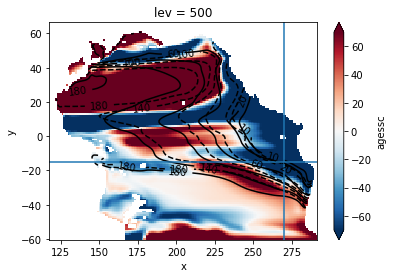

In [56]:
def _pre(ds):
    ds_out = regrid(ds)
    ds_out = ds_out.interp(lev=target_lev)
    ds_out['o2'] = convert_mol_m3_mymol_kg(ds_out['o2'])
    ds_out = mask_basin(ds_out)
    return ds_out


ds_hist_slice = _pre(ds_hist)
ds_fut_slice = _pre(ds_fut)

(ds_fut_slice.o2 - ds_hist_slice.o2).plot(vmax=10)

pp = ds_hist_slice.o2.plot.contour(levels=o2_contours, colors='k', linestyles='--')
plt.clabel(pp)
pp = ds_fut_slice.o2.plot.contour(levels=o2_contours, colors='k')
plt.clabel(pp)
plt.axvline(target_lon)
plt.axhline(target_lat)

plt.figure()
(ds_fut_slice.agessc - ds_hist_slice.agessc).plot(vmax=70)

pp = ds_hist_slice.o2.plot.contour(levels=o2_contours, colors='k', linestyles='--')
plt.clabel(pp)
pp = ds_fut_slice.o2.plot.contour(levels=o2_contours, colors='k')
plt.clabel(pp)
plt.axvline(target_lon)
plt.axhline(target_lat)

/scratch/gpfs/jbusecke/conda_tigercpu/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/scratch/gpfs/jbusecke/conda_tigercpu/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


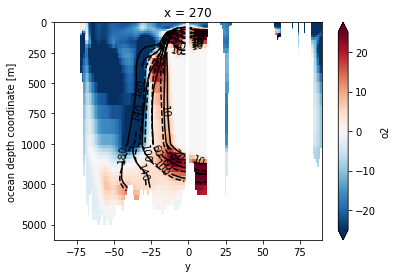

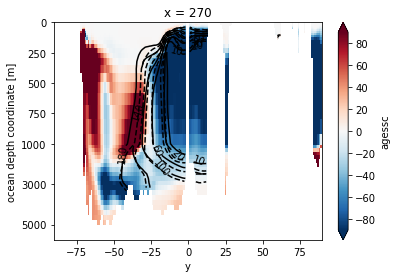

In [59]:
def _pre(ds):
    ds_out = regrid(ds)
    ds_out = ds_out.interp(x=target_lon)
    ds_out['o2'] = convert_mol_m3_mymol_kg(ds_out['o2'])
    return ds_out


ds_hist_slice = _pre(ds_hist)
ds_fut_slice = _pre(ds_fut)

kwargs = dict(yincrease=False, y='lev')

(ds_fut_slice.o2 - ds_hist_slice.o2).plot(vmax=25)

pp = ds_hist_slice.o2.plot.contour(levels=o2_contours, colors='k', linestyles='--', **kwargs)
plt.clabel(pp)
pp = ds_fut_slice.o2.plot.contour(levels=o2_contours, colors='k', **kwargs)
plt.clabel(pp)
linear_piecewise_scale(1000, 5)
plt.gca().set_yticks([0, 250, 500, 750, 1000, 3000, 5000]);

plt.figure()
(ds_fut_slice.agessc - ds_hist_slice.agessc).plot(vmax=90)

pp = ds_hist_slice.o2.plot.contour(levels=o2_contours, colors='k', linestyles='--', **kwargs)
pp = ds_fut_slice.o2.plot.contour(levels=o2_contours, colors='k', **kwargs)
plt.clabel(pp)
linear_piecewise_scale(1000, 5)
plt.gca().set_yticks([0, 250, 500, 750, 1000, 3000, 5000]);

/scratch/gpfs/jbusecke/conda_tigercpu/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/scratch/gpfs/jbusecke/conda_tigercpu/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


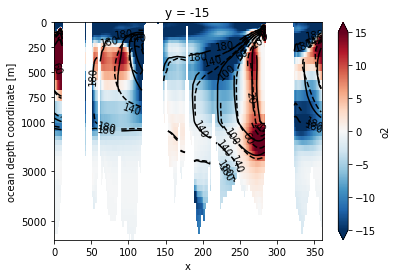

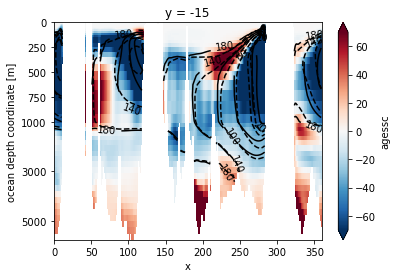

In [58]:
def _pre(ds):
    ds_out = regrid(ds)
    ds_out = ds_out.interp(y=target_lat)
    ds_out['o2'] = convert_mol_m3_mymol_kg(ds_out['o2'])
    return ds_out


ds_hist_slice = _pre(ds_hist)
ds_fut_slice = _pre(ds_fut)

kwargs = dict(yincrease=False, y='lev')

(ds_fut_slice.o2 - ds_hist_slice.o2).plot(vmax=15)

pp = ds_hist_slice.o2.plot.contour(levels=o2_contours, colors='k', linestyles='--', **kwargs)
plt.clabel(pp)
pp = ds_fut_slice.o2.plot.contour(levels=o2_contours, colors='k', **kwargs)
plt.clabel(pp)
linear_piecewise_scale(1000, 3)
plt.gca().set_yticks([0, 250, 500, 750, 1000, 3000, 5000]);

plt.figure()
(ds_fut_slice.agessc - ds_hist_slice.agessc).plot(vmax=70)

pp = ds_hist_slice.o2.plot.contour(levels=o2_contours, colors='k', linestyles='--', **kwargs)
pp = ds_fut_slice.o2.plot.contour(levels=o2_contours, colors='k', **kwargs)
plt.clabel(pp)
linear_piecewise_scale(1000, 3)
plt.gca().set_yticks([0, 250, 500, 750, 1000, 3000, 5000]);